In [1]:
# load libraries
import geopandas as gpd
import pandas as pd
import numpy as np
import os
import requests
from urllib.request import urlopen
import json
from shapely import wkt
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# load data into geopandas dataframe
gdf = gpd.read_file("https://opendata.arcgis.com/datasets/716338a41410457bb415a4bae2b2ad3e_0.geojson", low_memory=False)

# confirm load
gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [3]:
# check dataframe
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 281692 entries, 0 to 281691
Data columns (total 29 columns):
 #   Column               Non-Null Count   Dtype   
---  ------               --------------   -----   
 0   Index_               281692 non-null  int64   
 1   event_unique_id      281692 non-null  object  
 2   Division             281692 non-null  object  
 3   occurrencedate       281692 non-null  object  
 4   reporteddate         281692 non-null  object  
 5   location_type        281692 non-null  object  
 6   premises_type        281692 non-null  object  
 7   ucr_code             281692 non-null  int64   
 8   ucr_ext              281692 non-null  int64   
 9   offence              281692 non-null  object  
 10  reportedyear         281692 non-null  int64   
 11  reportedmonth        281692 non-null  object  
 12  reportedday          281692 non-null  int64   
 13  reporteddayofyear    281692 non-null  int64   
 14  reporteddayofweek    281692 non-null  object

In [4]:
# check column names - makes copying text for later steps easier
print(list(gdf.columns.values))

['Index_', 'event_unique_id', 'Division', 'occurrencedate', 'reporteddate', 'location_type', 'premises_type', 'ucr_code', 'ucr_ext', 'offence', 'reportedyear', 'reportedmonth', 'reportedday', 'reporteddayofyear', 'reporteddayofweek', 'reportedhour', 'occurrenceyear', 'occurrencemonth', 'occurrenceday', 'occurrencedayofyear', 'occurrencedayofweek', 'occurrencehour', 'MCI', 'Hood_ID', 'Neighbourhood', 'Long', 'Lat', 'ObjectId', 'geometry']


In [5]:
# look at data
gdf.head()

,Index_,event_unique_id,Division,occurrencedate,reporteddate,location_type,premises_type,ucr_code,ucr_ext,offence,...,occurrencedayofyear,occurrencedayofweek,occurrencehour,MCI,Hood_ID,Neighbourhood,Long,Lat,ObjectId,geometry
0,110,GO-20141625305,D23,2014-03-02T05:00:00,2014-03-02T05:00:00,"Single Home, House (Attach Garage, Cottage, Mo...",House,1430,100,Assault,...,61,Sunday,8,Assault,1,West Humber-Clairville,-79.590332,43.734013,1,POINT (-79.59033 43.73401)
1,188,GO-20141272968,D23,2013-12-24T05:00:00,2014-01-03T05:00:00,"Commercial Dwelling Unit (Hotel, Motel, B & B,...",Commercial,1610,200,Robbery - Mugging,...,358,Tuesday,22,Robbery,1,West Humber-Clairville,-79.600701,43.731834,2,POINT (-79.60070 43.73183)
2,287,GO-20141284361,D23,2013-01-05T05:00:00,2014-01-05T05:00:00,"Commercial Dwelling Unit (Hotel, Motel, B & B,...",Commercial,1430,100,Assault,...,5,Saturday,4,Assault,1,West Humber-Clairville,-79.600794,43.686423,3,POINT (-79.60079 43.68642)
3,384,GO-20141292177,D23,2013-12-31T05:00:00,2014-01-06T05:00:00,Other Commercial / Corporate Places (For Profi...,Commercial,2120,200,B&E,...,365,Tuesday,21,Break and Enter,1,West Humber-Clairville,-79.603876,43.743642,4,POINT (-79.60388 43.74364)
4,438,GO-20141297201,D23,2014-01-03T05:00:00,2014-01-07T05:00:00,Other Commercial / Corporate Places (For Profi...,Commercial,2120,200,B&E,...,3,Friday,10,Break and Enter,1,West Humber-Clairville,-79.586443,43.697108,5,POINT (-79.58644 43.69711)


In [6]:
# drop columns we don't need
cols2drop = ['Index_', 'Division', 'reporteddate', 'ucr_code', 'ucr_ext', 'reportedyear', 'reportedmonth', 
             'reportedday', 'reporteddayofyear', 'reporteddayofweek', 'reportedhour']
for col in gdf.columns:
    if col in cols2drop:
        gdf.drop(col, inplace=True, axis=1)
        
# confirm reduced dataframe
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 281692 entries, 0 to 281691
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype   
---  ------               --------------   -----   
 0   event_unique_id      281692 non-null  object  
 1   occurrencedate       281692 non-null  object  
 2   location_type        281692 non-null  object  
 3   premises_type        281692 non-null  object  
 4   offence              281692 non-null  object  
 5   occurrenceyear       281692 non-null  int64   
 6   occurrencemonth      281692 non-null  object  
 7   occurrenceday        281692 non-null  int64   
 8   occurrencedayofyear  281692 non-null  int64   
 9   occurrencedayofweek  281692 non-null  object  
 10  occurrencehour       281692 non-null  int64   
 11  MCI                  281692 non-null  object  
 12  Hood_ID              281692 non-null  object  
 13  Neighbourhood        281692 non-null  object  
 14  Long                 281692 non-null  float6

In [7]:
# check column names again - makes copying text for later steps easier
print(list(gdf.columns.values))

['event_unique_id', 'occurrencedate', 'location_type', 'premises_type', 'offence', 'occurrenceyear', 'occurrencemonth', 'occurrenceday', 'occurrencedayofyear', 'occurrencedayofweek', 'occurrencehour', 'MCI', 'Hood_ID', 'Neighbourhood', 'Long', 'Lat', 'ObjectId', 'geometry']


In [8]:
# count nulls by columns to identify if there are any problems
gdf.isnull().sum(axis=0).sort_values(ascending=False)

geometry               0
ObjectId               0
occurrencedate         0
location_type          0
premises_type          0
offence                0
occurrenceyear         0
occurrencemonth        0
occurrenceday          0
occurrencedayofyear    0
occurrencedayofweek    0
occurrencehour         0
MCI                    0
Hood_ID                0
Neighbourhood          0
Long                   0
Lat                    0
event_unique_id        0
dtype: int64

In [9]:
# count nulls by rows
gdf.isnull().sum(axis=1).sort_values(ascending=False)

281691    0
93898     0
93892     0
93893     0
93894     0
         ..
187789    0
187788    0
187787    0
187786    0
0         0
Length: 281692, dtype: int64

In [10]:
# no null values - great!
# now count nans by columns
gdf.isna().sum(axis=0).sort_values(ascending=False)

geometry               0
ObjectId               0
occurrencedate         0
location_type          0
premises_type          0
offence                0
occurrenceyear         0
occurrencemonth        0
occurrenceday          0
occurrencedayofyear    0
occurrencedayofweek    0
occurrencehour         0
MCI                    0
Hood_ID                0
Neighbourhood          0
Long                   0
Lat                    0
event_unique_id        0
dtype: int64

In [11]:
# count nans by rows
gdf.isna().sum(axis=1).sort_values(ascending=False)

281691    0
93898     0
93892     0
93893     0
93894     0
         ..
187789    0
187788    0
187787    0
187786    0
0         0
Length: 281692, dtype: int64

In [12]:
# no nans - great!
# documentation indicates that for locations identified outside the city of Toronto limits or as invalidated locations
# the division/neighbourhood designation will be ‘NSA’ to indicate ‘Not Specified Area.’
# we will identify and delete these as we are only concerned with occurences with identifiable locations
gdf.loc[gdf['Hood_ID'] == 'NSA']

,event_unique_id,occurrencedate,location_type,premises_type,offence,occurrenceyear,occurrencemonth,occurrenceday,occurrencedayofyear,occurrencedayofweek,occurrencehour,MCI,Hood_ID,Neighbourhood,Long,Lat,ObjectId,geometry
277000,GO-2016123990,2016-01-20T05:00:00,Jails / Detention Centres,Other,Assault,2016,January,20,20,Wednesday,11,Assault,NSA,NSA,0.000000,0.000000,277001,POINT (0.00000 0.00000)
277001,GO-2016134961,2016-01-23T05:00:00,"Streets, Roads, Highways (Bicycle Path, Privat...",Outside,Assault,2016,January,23,23,Saturday,10,Assault,NSA,NSA,0.000000,0.000000,277002,POINT (0.00000 0.00000)
277002,GO-2016137475,2016-01-23T05:00:00,"Apartment (Rooming House, Condo)",Apartment,Aggravated Assault,2016,January,23,23,Saturday,5,Assault,NSA,NSA,-79.747735,43.690595,277003,POINT (-79.74773 43.69059)
277003,GO-2016137475,2016-01-23T05:00:00,"Apartment (Rooming House, Condo)",Apartment,Aggravated Assault,2016,January,23,23,Saturday,5,Assault,NSA,NSA,-79.747735,43.690595,277004,POINT (-79.74773 43.69059)
277004,GO-2016139799,2016-01-24T05:00:00,Bar / Restaurant,Commercial,Assault With Weapon,2016,January,24,24,Sunday,4,Assault,NSA,NSA,0.000000,0.000000,277005,POINT (0.00000 0.00000)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
281687,GO-20212225907,2021-10-22T04:00:00,"Single Home, House (Attach Garage, Cottage, Mo...",House,B&E,2021,October,22,295,Friday,9,Break and Enter,NSA,NSA,-79.245151,43.838010,281688,POINT (-79.24515 43.83801)
281688,GO-20212226010,2021-10-08T04:00:00,"Single Home, House (Attach Garage, Cottage, Mo...",House,B&E,2021,October,8,281,Friday,12,Break and Enter,NSA,NSA,-79.286862,43.847594,281689,POINT (-79.28686 43.84759)
281689,GO-20212238042,2021-11-20T05:00:00,"Apartment (Rooming House, Condo)",Apartment,Assault,2021,November,20,324,Saturday,13,Assault,NSA,NSA,-79.533763,43.931775,281690,POINT (-79.53376 43.93177)
281690,GO-20212240466,2021-11-18T05:00:00,"Single Home, House (Attach Garage, Cottage, Mo...",House,Assault,2021,November,18,322,Thursday,18,Assault,NSA,NSA,0.000000,0.000000,281691,POINT (0.00000 0.00000)


In [13]:
# it seems that when 'Hood_ID' == NSA, 'Neighbourhood' is also NSA, let's check to see if we get the same results
gdf.loc[gdf['Neighbourhood'] == 'NSA']

,event_unique_id,occurrencedate,location_type,premises_type,offence,occurrenceyear,occurrencemonth,occurrenceday,occurrencedayofyear,occurrencedayofweek,occurrencehour,MCI,Hood_ID,Neighbourhood,Long,Lat,ObjectId,geometry
277000,GO-2016123990,2016-01-20T05:00:00,Jails / Detention Centres,Other,Assault,2016,January,20,20,Wednesday,11,Assault,NSA,NSA,0.000000,0.000000,277001,POINT (0.00000 0.00000)
277001,GO-2016134961,2016-01-23T05:00:00,"Streets, Roads, Highways (Bicycle Path, Privat...",Outside,Assault,2016,January,23,23,Saturday,10,Assault,NSA,NSA,0.000000,0.000000,277002,POINT (0.00000 0.00000)
277002,GO-2016137475,2016-01-23T05:00:00,"Apartment (Rooming House, Condo)",Apartment,Aggravated Assault,2016,January,23,23,Saturday,5,Assault,NSA,NSA,-79.747735,43.690595,277003,POINT (-79.74773 43.69059)
277003,GO-2016137475,2016-01-23T05:00:00,"Apartment (Rooming House, Condo)",Apartment,Aggravated Assault,2016,January,23,23,Saturday,5,Assault,NSA,NSA,-79.747735,43.690595,277004,POINT (-79.74773 43.69059)
277004,GO-2016139799,2016-01-24T05:00:00,Bar / Restaurant,Commercial,Assault With Weapon,2016,January,24,24,Sunday,4,Assault,NSA,NSA,0.000000,0.000000,277005,POINT (0.00000 0.00000)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
281687,GO-20212225907,2021-10-22T04:00:00,"Single Home, House (Attach Garage, Cottage, Mo...",House,B&E,2021,October,22,295,Friday,9,Break and Enter,NSA,NSA,-79.245151,43.838010,281688,POINT (-79.24515 43.83801)
281688,GO-20212226010,2021-10-08T04:00:00,"Single Home, House (Attach Garage, Cottage, Mo...",House,B&E,2021,October,8,281,Friday,12,Break and Enter,NSA,NSA,-79.286862,43.847594,281689,POINT (-79.28686 43.84759)
281689,GO-20212238042,2021-11-20T05:00:00,"Apartment (Rooming House, Condo)",Apartment,Assault,2021,November,20,324,Saturday,13,Assault,NSA,NSA,-79.533763,43.931775,281690,POINT (-79.53376 43.93177)
281690,GO-20212240466,2021-11-18T05:00:00,"Single Home, House (Attach Garage, Cottage, Mo...",House,Assault,2021,November,18,322,Thursday,18,Assault,NSA,NSA,0.000000,0.000000,281691,POINT (0.00000 0.00000)


In [14]:
# they match! we will delete these
gdf = gdf[gdf.Hood_ID != 'NSA']
gdf = gdf[gdf.Neighbourhood != 'NSA']

# confirm reduced dataframe
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 277071 entries, 0 to 277185
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype   
---  ------               --------------   -----   
 0   event_unique_id      277071 non-null  object  
 1   occurrencedate       277071 non-null  object  
 2   location_type        277071 non-null  object  
 3   premises_type        277071 non-null  object  
 4   offence              277071 non-null  object  
 5   occurrenceyear       277071 non-null  int64   
 6   occurrencemonth      277071 non-null  object  
 7   occurrenceday        277071 non-null  int64   
 8   occurrencedayofyear  277071 non-null  int64   
 9   occurrencedayofweek  277071 non-null  object  
 10  occurrencehour       277071 non-null  int64   
 11  MCI                  277071 non-null  object  
 12  Hood_ID              277071 non-null  object  
 13  Neighbourhood        277071 non-null  object  
 14  Long                 277071 non-null  float6

In [15]:
# Confirm reduction meets amount in NSA query
x = 281692-277071
print(x)

4621


In [16]:
# save reduced data
path = os.path.join('data','rough')
fn = 'crimeData.csv.gz'
print(f"Writing to: {fn}")

if not os.path.exists(path):
    print(f"Creating {path} under {os.getcwd()}")
    os.makedirs(path)
    
gdf.to_csv(os.path.join(path,fn), index=False, compression="gzip")
print("Done.")

Writing to: crimeData.csv.gz
Done.


In [17]:
# reload reduced data
crime = gdf

# have a look at data
crime.head(10)

,event_unique_id,occurrencedate,location_type,premises_type,offence,occurrenceyear,occurrencemonth,occurrenceday,occurrencedayofyear,occurrencedayofweek,occurrencehour,MCI,Hood_ID,Neighbourhood,Long,Lat,ObjectId,geometry
0,GO-20141625305,2014-03-02T05:00:00,"Single Home, House (Attach Garage, Cottage, Mo...",House,Assault,2014,March,2,61,Sunday,8,Assault,1,West Humber-Clairville,-79.590332,43.734013,1,POINT (-79.59033 43.73401)
1,GO-20141272968,2013-12-24T05:00:00,"Commercial Dwelling Unit (Hotel, Motel, B & B,...",Commercial,Robbery - Mugging,2013,December,24,358,Tuesday,22,Robbery,1,West Humber-Clairville,-79.600701,43.731834,2,POINT (-79.60070 43.73183)
2,GO-20141284361,2013-01-05T05:00:00,"Commercial Dwelling Unit (Hotel, Motel, B & B,...",Commercial,Assault,2013,January,5,5,Saturday,4,Assault,1,West Humber-Clairville,-79.600794,43.686423,3,POINT (-79.60079 43.68642)
3,GO-20141292177,2013-12-31T05:00:00,Other Commercial / Corporate Places (For Profi...,Commercial,B&E,2013,December,31,365,Tuesday,21,Break and Enter,1,West Humber-Clairville,-79.603876,43.743642,4,POINT (-79.60388 43.74364)
4,GO-20141297201,2014-01-03T05:00:00,Other Commercial / Corporate Places (For Profi...,Commercial,B&E,2014,January,3,3,Friday,10,Break and Enter,1,West Humber-Clairville,-79.586443,43.697108,5,POINT (-79.58644 43.69711)
5,GO-20141302953,2014-01-08T05:00:00,"Construction Site (Warehouse, Trailer, Shed)",Commercial,Theft Over,2014,January,8,8,Wednesday,2,Theft Over,1,West Humber-Clairville,-79.584931,43.678342,6,POINT (-79.58493 43.67834)
6,GO-20141304312,2014-01-08T05:00:00,"Single Home, House (Attach Garage, Cottage, Mo...",House,B&E,2014,January,8,8,Wednesday,11,Break and Enter,1,West Humber-Clairville,-79.620043,43.722990,7,POINT (-79.62004 43.72299)
7,GO-20141303907,2014-01-06T05:00:00,Other Commercial / Corporate Places (For Profi...,Commercial,Theft Over,2014,January,6,6,Monday,0,Theft Over,1,West Humber-Clairville,-79.584931,43.678342,8,POINT (-79.58493 43.67834)
8,GO-20141312296,2013-12-26T05:00:00,Other Non Commercial / Corporate Places (Non-P...,Other,Theft Over,2013,December,26,360,Thursday,14,Theft Over,1,West Humber-Clairville,-79.588362,43.702625,9,POINT (-79.58836 43.70263)
9,GO-20141319035,2014-01-10T05:00:00,"Single Home, House (Attach Garage, Cottage, Mo...",House,B&E,2014,January,10,10,Friday,18,Break and Enter,1,West Humber-Clairville,-79.624434,43.728138,10,POINT (-79.62443 43.72814)


In [18]:
# Data review

# 1. crime types - 2 fields
    # offence and MCI fields - from documentation, we know that offence is a non-standardized open field, whereas MCI is categorized
    # we will drop offence and keep MCI
    
# 2. neighbourhood - 2 fields
    # Hood_ID and Neighbourhood fields are duplicates, but should bothe be left in for fleixbility in matching with neighoburhood polygons later
    # we will check unique values to ensure both have the same amount and keep both of these 
    
# 3. cateogrical fields - 4 fields
    # location_type, premises_type, MCI, and Neighbourhood fields are all categorical data as indicated in the documentation
    # location_type is too detailed for our purposes
    # we will delete location_type and convert the rest to categories - NOTE GPKG WOULD NOT ALLOW CATEGORIES
    
# 4. ids - 2 fields
    # event_unique_id and ObjectId fields seem to both be unique values, but they are different data types
    # documentation suggests that occurences with multiple types of crimes will show up as multiple entries
    # therefore, one of these fields will have multiple entries and the other will have unique values - we will need to confirm differences, address them, and possibly convert to int

# 5. dates - 7 fields
    # occurrencedate, occurrenceyear, occurrencemonth, occurrenceday, occurrencedayofyear, occurrencedayofweek, and occurrencehour fields
    # occurencedate is generalized and is sufficient for our purposes, we will delete the rest
    
# 6. location - 3 fields
    # we will keep geometry
    # we will check lat and long to see if there are outliers to remove, then we will delete them

In [19]:
# 1 - drop offence field
cols2drop2 = ['location_type','offence']

for col in crime.columns:
    if col in cols2drop2:
        crime.drop(col, inplace=True, axis=1)
        
# confirm removal - makes copying text for later steps easier
print(list(crime.columns.values))    

['event_unique_id', 'occurrencedate', 'premises_type', 'occurrenceyear', 'occurrencemonth', 'occurrenceday', 'occurrencedayofyear', 'occurrencedayofweek', 'occurrencehour', 'MCI', 'Hood_ID', 'Neighbourhood', 'Long', 'Lat', 'ObjectId', 'geometry']


In [20]:
# 2 - count unique values of neighbourhood fields
count1 = crime.Hood_ID.nunique()
count2 = crime.Neighbourhood.nunique()
print(count1)
print(count2)

140
140


In [21]:
# they match and we will keep both

# NOTE gpkg will not accept categories so the rest of this cell has been hashed out

# 3 - convert location_type, premises_type, MCI, and neighbourhood fields to cateogrical data
#for c in ['premises_type', 'MCI', 'Neighbourhood']:
#    crime[c] = crime[c].astype('category')
    
# confirm conversion to categories
#crime.info()

In [22]:
# we will also convert Hood_ID to int
for c in ['Hood_ID']:
    crime[c] = crime[c].astype('int')

# confirm conversion to int
crime.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 277071 entries, 0 to 277185
Data columns (total 16 columns):
 #   Column               Non-Null Count   Dtype   
---  ------               --------------   -----   
 0   event_unique_id      277071 non-null  object  
 1   occurrencedate       277071 non-null  object  
 2   premises_type        277071 non-null  object  
 3   occurrenceyear       277071 non-null  int64   
 4   occurrencemonth      277071 non-null  object  
 5   occurrenceday        277071 non-null  int64   
 6   occurrencedayofyear  277071 non-null  int64   
 7   occurrencedayofweek  277071 non-null  object  
 8   occurrencehour       277071 non-null  int64   
 9   MCI                  277071 non-null  object  
 10  Hood_ID              277071 non-null  int64   
 11  Neighbourhood        277071 non-null  object  
 12  Long                 277071 non-null  float64 
 13  Lat                  277071 non-null  float64 
 14  ObjectId             277071 non-null  int64 

In [23]:
# 4 - we have 277071 rows, let's check count of unique values of id fields compared to rows
count3 = crime.event_unique_id.nunique()
count4 = crime.ObjectId.nunique()
print(count3)
print(count4)

241242
277071


In [24]:
# the event_unique_id field has duplicate values, whereas the ObjectID field has a unique value for every row
# as per documentation one event can have mutliple crime types - for example, a single event could have both an assault and a theft
# for our purposes, we want to ensure we count each crime type seperately
# we will delete the event_unique_id field and keep the ObjectId field
cols2drop3 = ['event_unique_id']

for col in crime.columns:
    if col in cols2drop3:
        crime.drop(col, inplace=True, axis=1)
        
# confirm removal - makes copying text for later steps easier
print(list(crime.columns.values))

['occurrencedate', 'premises_type', 'occurrenceyear', 'occurrencemonth', 'occurrenceday', 'occurrencedayofyear', 'occurrencedayofweek', 'occurrencehour', 'MCI', 'Hood_ID', 'Neighbourhood', 'Long', 'Lat', 'ObjectId', 'geometry']


In [25]:
# 5 - check dates fields
dates = crime[['occurrencedate', 'occurrenceyear', 'occurrencemonth', 'occurrenceday', 'occurrencedayofyear', 'occurrencedayofweek', 'occurrencehour']]
dates.head(10)

,occurrencedate,occurrenceyear,occurrencemonth,occurrenceday,occurrencedayofyear,occurrencedayofweek,occurrencehour
0,2014-03-02T05:00:00,2014,March,2,61,Sunday,8
1,2013-12-24T05:00:00,2013,December,24,358,Tuesday,22
2,2013-01-05T05:00:00,2013,January,5,5,Saturday,4
3,2013-12-31T05:00:00,2013,December,31,365,Tuesday,21
4,2014-01-03T05:00:00,2014,January,3,3,Friday,10
5,2014-01-08T05:00:00,2014,January,8,8,Wednesday,2
6,2014-01-08T05:00:00,2014,January,8,8,Wednesday,11
7,2014-01-06T05:00:00,2014,January,6,6,Monday,0
8,2013-12-26T05:00:00,2013,December,26,360,Thursday,14
9,2014-01-10T05:00:00,2014,January,10,10,Friday,18


In [26]:
# for our purposes occurrencedate is all that is required and the rest can be dropped
cols2drop4 = ['occurrenceyear', 'occurrencemonth', 'occurrenceday', 'occurrencedayofyear', 'occurrencedayofweek', 'occurrencehour']

for col in crime.columns:
    if col in cols2drop4:
        crime.drop(col, inplace=True, axis=1)
        
# confirm removal - makes copying text for later steps easier
print(list(crime.columns.values))

['occurrencedate', 'premises_type', 'MCI', 'Hood_ID', 'Neighbourhood', 'Long', 'Lat', 'ObjectId', 'geometry']


In [27]:
# 6 - we will check lat and long fields for outliers
location = crime[['Long', 'Lat']]
location.describe()

,Long,Lat
count,277071.000000,277071.000000
mean,-79.316298,43.662951
std,2.515793,1.384753
min,-79.639225,0.000000
25%,-79.471352,43.660816
50%,-79.393738,43.700298
75%,-79.323951,43.751440
max,0.000000,43.853752


In [28]:
# min in the lat field is showing as 0 which is definitely not in Toronto

# let's check how many values are equal to 0
print((crime['Lat'] == 0).sum())

# vs. all values
print((crime['Lat']).count())

278
277071


In [29]:
# delete these values
crime = crime[crime.Lat != 0]

In [30]:
# check values again
location2 = crime[['Long', 'Lat']]
location2.describe()

,Long,Lat
count,276793.000000,276793.000000
mean,-79.395960,43.706804
std,0.103416,0.052630
min,-79.639225,43.587092
25%,-79.471430,43.660875
50%,-79.393857,43.700415
75%,-79.324291,43.751474
max,-79.123062,43.853752


In [31]:
# that fixed the problem
# let's have another look at the data
crime.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 276793 entries, 0 to 277185
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype   
---  ------          --------------   -----   
 0   occurrencedate  276793 non-null  object  
 1   premises_type   276793 non-null  object  
 2   MCI             276793 non-null  object  
 3   Hood_ID         276793 non-null  int64   
 4   Neighbourhood   276793 non-null  object  
 5   Long            276793 non-null  float64 
 6   Lat             276793 non-null  float64 
 7   ObjectId        276793 non-null  int64   
 8   geometry        276793 non-null  geometry
dtypes: float64(2), geometry(1), int64(2), object(4)
memory usage: 21.1+ MB


In [32]:
# 278 rows have been removed
# another look
crime.head(10)

,occurrencedate,premises_type,MCI,Hood_ID,Neighbourhood,Long,Lat,ObjectId,geometry
0,2014-03-02T05:00:00,House,Assault,1,West Humber-Clairville,-79.590332,43.734013,1,POINT (-79.59033 43.73401)
1,2013-12-24T05:00:00,Commercial,Robbery,1,West Humber-Clairville,-79.600701,43.731834,2,POINT (-79.60070 43.73183)
2,2013-01-05T05:00:00,Commercial,Assault,1,West Humber-Clairville,-79.600794,43.686423,3,POINT (-79.60079 43.68642)
3,2013-12-31T05:00:00,Commercial,Break and Enter,1,West Humber-Clairville,-79.603876,43.743642,4,POINT (-79.60388 43.74364)
4,2014-01-03T05:00:00,Commercial,Break and Enter,1,West Humber-Clairville,-79.586443,43.697108,5,POINT (-79.58644 43.69711)
5,2014-01-08T05:00:00,Commercial,Theft Over,1,West Humber-Clairville,-79.584931,43.678342,6,POINT (-79.58493 43.67834)
6,2014-01-08T05:00:00,House,Break and Enter,1,West Humber-Clairville,-79.620043,43.722990,7,POINT (-79.62004 43.72299)
7,2014-01-06T05:00:00,Commercial,Theft Over,1,West Humber-Clairville,-79.584931,43.678342,8,POINT (-79.58493 43.67834)
8,2013-12-26T05:00:00,Other,Theft Over,1,West Humber-Clairville,-79.588362,43.702625,9,POINT (-79.58836 43.70263)
9,2014-01-10T05:00:00,House,Break and Enter,1,West Humber-Clairville,-79.624434,43.728138,10,POINT (-79.62443 43.72814)


In [33]:
# we can now delete Long and Lat columns
cols2drop5 = ['Long', 'Lat']

for col in crime.columns:
    if col in cols2drop5:
        crime.drop(col, inplace=True, axis=1)
        
# confirm removal - makes copying text for later steps easier
print(list(crime.columns.values))

['occurrencedate', 'premises_type', 'MCI', 'Hood_ID', 'Neighbourhood', 'ObjectId', 'geometry']


/opt/conda/envs/sds2020/lib/python3.7/site-packages/pandas/core/frame.py:4169: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [34]:
# as we are completing an analysis of the impact of COVID-19 lockdowns on crime, we will add an additonal column for lockdown information
# from research we know that Toronto had three lockdowns as follows:

lockdown = {'ONE':['2020-03-23','2020-07-31'],
            'TWO':['2020-11-23','2021-03-08'],
            'THREE':['2021-04-08','2021-06-02']}

crime['occurrencedate'] = pd.to_datetime(crime.occurrencedate.values, infer_datetime_format=True)

for k, (s,e) in lockdown.items():
    crime.loc[crime['occurrencedate'].between(s,e), 'lockdownNum'] = k

crime.head()

/opt/conda/envs/sds2020/lib/python3.7/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/opt/conda/envs/sds2020/lib/python3.7/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


,occurrencedate,premises_type,MCI,Hood_ID,Neighbourhood,ObjectId,geometry,lockdownNum
0,2014-03-02 05:00:00,House,Assault,1,West Humber-Clairville,1,POINT (-79.59033 43.73401),NaN
1,2013-12-24 05:00:00,Commercial,Robbery,1,West Humber-Clairville,2,POINT (-79.60070 43.73183),NaN
2,2013-01-05 05:00:00,Commercial,Assault,1,West Humber-Clairville,3,POINT (-79.60079 43.68642),NaN
3,2013-12-31 05:00:00,Commercial,Break and Enter,1,West Humber-Clairville,4,POINT (-79.60388 43.74364),NaN
4,2014-01-03 05:00:00,Commercial,Break and Enter,1,West Humber-Clairville,5,POINT (-79.58644 43.69711),NaN


In [35]:
# replace NaN values in lockdownNum field with NONE (no lockdown)
crime['lockdownNum'] = crime['lockdownNum'].fillna('NONE')

# check revised number of occurrences by lockdownNum
crime.lockdownNum.value_counts()

/opt/conda/envs/sds2020/lib/python3.7/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


NONE     252020
ONE       11542
TWO        8412
THREE      4819
Name: lockdownNum, dtype: int64

In [36]:
# NOTE gpkg will not accept categories so this cell has been hashed out

# convert lockdownNum field to categorical data
#for c in ['lockdownNum']:
#    crime[c] = crime[c].astype('category')

# confirm changes
#crime.info()

In [37]:
# create a binary lockdown column based on lockdownNum column where 1 = in lockdown, and 0 = not in lockdown
crime['lockdownBinary'] = ['1' if x == 'ONE' else '1' if x == 'TWO' else '1' if x == 'THREE' else '0' for x in crime['lockdownNum']]

#confirm new column
crime.head()

,occurrencedate,premises_type,MCI,Hood_ID,Neighbourhood,ObjectId,geometry,lockdownNum,lockdownBinary
0,2014-03-02 05:00:00,House,Assault,1,West Humber-Clairville,1,POINT (-79.59033 43.73401),NONE,0
1,2013-12-24 05:00:00,Commercial,Robbery,1,West Humber-Clairville,2,POINT (-79.60070 43.73183),NONE,0
2,2013-01-05 05:00:00,Commercial,Assault,1,West Humber-Clairville,3,POINT (-79.60079 43.68642),NONE,0
3,2013-12-31 05:00:00,Commercial,Break and Enter,1,West Humber-Clairville,4,POINT (-79.60388 43.74364),NONE,0
4,2014-01-03 05:00:00,Commercial,Break and Enter,1,West Humber-Clairville,5,POINT (-79.58644 43.69711),NONE,0


In [38]:
# check datatypes
crime.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 276793 entries, 0 to 277185
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   occurrencedate  276793 non-null  datetime64[ns]
 1   premises_type   276793 non-null  object        
 2   MCI             276793 non-null  object        
 3   Hood_ID         276793 non-null  int64         
 4   Neighbourhood   276793 non-null  object        
 5   ObjectId        276793 non-null  int64         
 6   geometry        276793 non-null  geometry      
 7   lockdownNum     276793 non-null  object        
 8   lockdownBinary  276793 non-null  object        
dtypes: datetime64[ns](1), geometry(1), int64(2), object(5)
memory usage: 21.1+ MB


In [39]:
# convert lockdownBinary to int
for c in ['lockdownBinary']:
    crime[c] = crime[c].astype('int')
    
# confirm conversion to int
crime.info()

/opt/conda/envs/sds2020/lib/python3.7/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 276793 entries, 0 to 277185
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   occurrencedate  276793 non-null  datetime64[ns]
 1   premises_type   276793 non-null  object        
 2   MCI             276793 non-null  object        
 3   Hood_ID         276793 non-null  int64         
 4   Neighbourhood   276793 non-null  object        
 5   ObjectId        276793 non-null  int64         
 6   geometry        276793 non-null  geometry      
 7   lockdownNum     276793 non-null  object        
 8   lockdownBinary  276793 non-null  int64         
dtypes: datetime64[ns](1), geometry(1), int64(3), object(4)
memory usage: 21.1+ MB


In [40]:
# random check of data frame
crime.sample(frac=0.5)

,occurrencedate,premises_type,MCI,Hood_ID,Neighbourhood,ObjectId,geometry,lockdownNum,lockdownBinary
157908,2021-01-06 05:00:00,Outside,Assault,77,Waterfront Communities-The Island,157909,POINT (-79.38275 43.64264),TWO,1
115467,2016-01-02 05:00:00,Outside,Robbery,70,South Riverdale,115468,POINT (-79.34036 43.66817),NONE,0
30571,2020-02-03 05:00:00,Apartment,Assault,17,Mimico,30572,POINT (-79.47864 43.62483),NONE,0
242687,2016-03-31 04:00:00,Commercial,Assault,126,Dorset Park,242688,POINT (-79.27574 43.75192),NONE,0
8065,2017-10-31 04:00:00,House,Break and Enter,2,Mount Olive-Silverstone-Jamestown,8066,POINT (-79.58265 43.73839),NONE,0
...,...,...,...,...,...,...,...,...,...
125346,2018-11-13 05:00:00,Apartment,Assault,73,Moss Park,125347,POINT (-79.36496 43.65694),NONE,0
120595,2017-12-07 05:00:00,Apartment,Assault,72,Regent Park,120596,POINT (-79.35605 43.66166),NONE,0
242965,2018-02-23 05:00:00,Commercial,Robbery,126,Dorset Park,242966,POINT (-79.28222 43.76942),NONE,0
109522,2014-08-24 04:00:00,Outside,Assault,65,Greenwood-Coxwell,109523,POINT (-79.32211 43.67469),NONE,0


In [41]:
# save crime as clean data
path = os.path.join('data','clean')
fn = 'crimeData.csv.gz'
print(f"Writing to: {fn}")

if not os.path.exists(path):
    print(f"Creating {path} under {os.getcwd()}")
    os.makedirs(path)
    
crime.to_csv(os.path.join(path,fn), index=False, compression="gzip")
print("Done.")

Writing to: crimeData.csv.gz
Done.


In [42]:
# save crime as geodataframe

# Set save location
path = os.path.join('data','geo')
fn = 'crimeData.gpkg'
print(f"Writing to: {fn}")

if not os.path.exists(path):
    print(f"Creating {path} under {os.getcwd()}")
    os.makedirs(path)

crime.to_file(os.path.join(path,fn), index=False, driver='GPKG')
print("Done.")

Writing to: crimeData.gpkg
Done.


In [43]:
# now let's look at the Covid case data
# open covid-19 case data into a pandas dataframe

url = 'https://ckan0.cf.opendata.inter.prod-toronto.ca/dataset/64b54586-6180-4485-83eb-81e8fae3b8fe/resource/fff4ee65-3527-43be-9a8a-cb9401377dbc/download/COVID19%20cases.csv'
covidcases = pd.read_csv(url, low_memory=False)

# confirm load
print(f"Data frame is {covidcases.shape[0]:,} rows x {covidcases.shape[1]} columns")

Data frame is 303,859 rows x 18 columns


In [44]:
# check dataframe
covidcases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303859 entries, 0 to 303858
Data columns (total 18 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   _id                     303859 non-null  int64 
 1   Assigned_ID             303859 non-null  int64 
 2   Outbreak Associated     303859 non-null  object
 3   Age Group               303559 non-null  object
 4   Neighbourhood Name      295882 non-null  object
 5   FSA                     299563 non-null  object
 6   Source of Infection     303859 non-null  object
 7   Classification          303859 non-null  object
 8   Episode Date            303859 non-null  object
 9   Reported Date           303859 non-null  object
 10  Client Gender           303859 non-null  object
 11  Outcome                 303859 non-null  object
 12  Currently Hospitalized  303859 non-null  object
 13  Currently in ICU        303859 non-null  object
 14  Currently Intubated     303859 non-n

In [45]:
# check column names - makes copying text for later steps easier
print(list(covidcases.columns.values))

['_id', 'Assigned_ID', 'Outbreak Associated', 'Age Group', 'Neighbourhood Name', 'FSA', 'Source of Infection', 'Classification', 'Episode Date', 'Reported Date', 'Client Gender', 'Outcome', 'Currently Hospitalized', 'Currently in ICU', 'Currently Intubated', 'Ever Hospitalized', 'Ever in ICU', 'Ever Intubated']


In [46]:
# look at data
covidcases.head()

,_id,Assigned_ID,Outbreak Associated,Age Group,Neighbourhood Name,FSA,Source of Infection,Classification,Episode Date,Reported Date,Client Gender,Outcome,Currently Hospitalized,Currently in ICU,Currently Intubated,Ever Hospitalized,Ever in ICU,Ever Intubated
0,1,1,Sporadic,50 to 59 Years,Willowdale East,M2N,Travel,CONFIRMED,2020-01-22,2020-01-23,FEMALE,RESOLVED,No,No,No,No,No,No
1,2,2,Sporadic,50 to 59 Years,Willowdale East,M2N,Travel,CONFIRMED,2020-01-21,2020-01-23,MALE,RESOLVED,No,No,No,Yes,No,No
2,3,3,Sporadic,20 to 29 Years,Parkwoods-Donalda,M3A,Travel,CONFIRMED,2020-02-05,2020-02-21,FEMALE,RESOLVED,No,No,No,No,No,No
3,4,4,Sporadic,60 to 69 Years,Church-Yonge Corridor,M4W,Travel,CONFIRMED,2020-02-16,2020-02-25,FEMALE,RESOLVED,No,No,No,No,No,No
4,5,5,Sporadic,60 to 69 Years,Church-Yonge Corridor,M4W,Travel,CONFIRMED,2020-02-20,2020-02-26,MALE,RESOLVED,No,No,No,No,No,No


In [47]:
# save rough covid case data
path = os.path.join('data','rough')
fn = 'covidData.csv.gz'
print(f"Writing to: {fn}")

if not os.path.exists(path):
    print(f"Creating {path} under {os.getcwd()}")
    os.makedirs(path)
    
covidcases.to_csv(os.path.join(path,fn), index=False, compression="gzip")
print("Done.")

Writing to: covidData.csv.gz
Done.


In [48]:
# reload rough covid case data
path = os.path.join('data','rough')
fn = 'covidData.csv.gz'
df = pd.read_csv(os.path.join(path,fn), compression='gzip', low_memory=False)

# have a look at data
df.head(10)

,_id,Assigned_ID,Outbreak Associated,Age Group,Neighbourhood Name,FSA,Source of Infection,Classification,Episode Date,Reported Date,Client Gender,Outcome,Currently Hospitalized,Currently in ICU,Currently Intubated,Ever Hospitalized,Ever in ICU,Ever Intubated
0,1,1,Sporadic,50 to 59 Years,Willowdale East,M2N,Travel,CONFIRMED,2020-01-22,2020-01-23,FEMALE,RESOLVED,No,No,No,No,No,No
1,2,2,Sporadic,50 to 59 Years,Willowdale East,M2N,Travel,CONFIRMED,2020-01-21,2020-01-23,MALE,RESOLVED,No,No,No,Yes,No,No
2,3,3,Sporadic,20 to 29 Years,Parkwoods-Donalda,M3A,Travel,CONFIRMED,2020-02-05,2020-02-21,FEMALE,RESOLVED,No,No,No,No,No,No
3,4,4,Sporadic,60 to 69 Years,Church-Yonge Corridor,M4W,Travel,CONFIRMED,2020-02-16,2020-02-25,FEMALE,RESOLVED,No,No,No,No,No,No
4,5,5,Sporadic,60 to 69 Years,Church-Yonge Corridor,M4W,Travel,CONFIRMED,2020-02-20,2020-02-26,MALE,RESOLVED,No,No,No,No,No,No
5,6,6,Sporadic,50 to 59 Years,Newtonbrook West,M2R,Travel,CONFIRMED,2020-02-24,2020-02-27,MALE,RESOLVED,No,No,No,No,No,No
6,7,7,Sporadic,80 to 89 Years,Milliken,M1V,Travel,CONFIRMED,2020-02-20,2020-02-28,MALE,RESOLVED,No,No,No,No,No,No
7,8,8,Sporadic,60 to 69 Years,Willowdale West,M2N,Travel,CONFIRMED,2020-02-21,2020-03-04,MALE,RESOLVED,No,No,No,Yes,No,No
8,9,9,Sporadic,50 to 59 Years,Willowdale East,M2N,Travel,CONFIRMED,2020-02-29,2020-02-29,MALE,RESOLVED,No,No,No,No,No,No
9,10,10,Sporadic,60 to 69 Years,Henry Farm,M2J,Travel,CONFIRMED,2020-02-26,2020-03-01,MALE,RESOLVED,No,No,No,No,No,No


In [49]:
# drop columns we don't need
cols2drop6 = ['Outbreak Associated', 'Age Group', 'Source of Infection', 'Client Gender', 'Outcome', 'Currently Hospitalized', 
              'Currently in ICU', 'Currently Intubated', 'Ever Hospitalized', 'Ever in ICU', 'Ever Intubated']
for col in df.columns:
    if col in cols2drop6:
        df.drop(col, inplace=True, axis=1)
        
# confirm reduced dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303859 entries, 0 to 303858
Data columns (total 7 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   _id                 303859 non-null  int64 
 1   Assigned_ID         303859 non-null  int64 
 2   Neighbourhood Name  295882 non-null  object
 3   FSA                 299563 non-null  object
 4   Classification      303859 non-null  object
 5   Episode Date        303859 non-null  object
 6   Reported Date       303859 non-null  object
dtypes: int64(2), object(5)
memory usage: 16.2+ MB


In [50]:
# check column names again - makes copying text for later steps easier
print(list(df.columns.values))

['_id', 'Assigned_ID', 'Neighbourhood Name', 'FSA', 'Classification', 'Episode Date', 'Reported Date']


In [51]:
# count nulls by columns to identify if there are any problems
df.isnull().sum(axis=0).sort_values(ascending=False)

Neighbourhood Name    7977
FSA                   4296
Reported Date            0
Episode Date             0
Classification           0
Assigned_ID              0
_id                      0
dtype: int64

In [52]:
# count nulls by rows
df.isnull().sum(axis=1).sort_values(ascending=False)

303858    2
253546    2
270289    2
270280    2
270277    2
         ..
199885    0
199886    0
199887    0
199888    0
0         0
Length: 303859, dtype: int64

In [53]:
# many null values
# let's look at remaining columns in more detail to see if we can drop more
df.head()[['_id', 'Assigned_ID', 'Neighbourhood Name', 'FSA', 'Classification', 'Episode Date', 'Reported Date']]

,_id,Assigned_ID,Neighbourhood Name,FSA,Classification,Episode Date,Reported Date
0,1,1,Willowdale East,M2N,CONFIRMED,2020-01-22,2020-01-23
1,2,2,Willowdale East,M2N,CONFIRMED,2020-01-21,2020-01-23
2,3,3,Parkwoods-Donalda,M3A,CONFIRMED,2020-02-05,2020-02-21
3,4,4,Church-Yonge Corridor,M4W,CONFIRMED,2020-02-16,2020-02-25
4,5,5,Church-Yonge Corridor,M4W,CONFIRMED,2020-02-20,2020-02-26


In [54]:
# Data review
# 1. ids - 2 fields
    # the _id and Assigned_ID fields seem to be identical and have the same amount
    # however, documentation suggests Assigned_ID is from Toronto Public Health, not the database, and cases can disappear
    # based on this, we will delete Assigned_ID

# 2. Locations - 2 fields
    # the Neighbourhood Name and Forward Sortation Area (FSA) fields both can be used to geolocate the cases
    # documentation suggests that the FSA field and Census Tracts (CTs) were used to determine the Neighbourhood Name
    # documentation also mentions that neighbourhood information is missing for cases with missing postalcodes
    # for our purposes aggregate numbers are okay and we don't need to geolocate so we will drop both of these fields 

# 3. Status - 1 field
    # According to the documentation, the Classification field classifies cases as either confirmed or probable
    # as with above, for our purposes, aggregate numbers are okay, we will delete probable cases and keep confirmed
    
# 4. dates - 2 fields
    # we do not need both of these dates, so we will keep the reported date as an official record and drop the episode date
    # change reported date to reported_date for ease
    
# drop columns we don't need
cols2drop7 = ['Assigned_ID', 'Neighbourhood Name', 'FSA', 'Episode Date']
for col in df.columns:
    if col in cols2drop7:
        df.drop(col, inplace=True, axis=1)
        
# confirm reduced dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303859 entries, 0 to 303858
Data columns (total 3 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   _id             303859 non-null  int64 
 1   Classification  303859 non-null  object
 2   Reported Date   303859 non-null  object
dtypes: int64(1), object(2)
memory usage: 7.0+ MB


In [55]:
# check column names again - makes copying text for later steps easier
print(list(df.columns.values))

['_id', 'Classification', 'Reported Date']


In [56]:
# count nulls by columns to identify if there are any problems
df.isnull().sum(axis=0).sort_values(ascending=False)

Reported Date     0
Classification    0
_id               0
dtype: int64

In [57]:
# count nulls by rows
df.isnull().sum(axis=1).sort_values(ascending=False)

303858    0
101280    0
101282    0
101283    0
101284    0
         ..
202572    0
202573    0
202574    0
202575    0
0         0
Length: 303859, dtype: int64

In [58]:
# no more nulls - perfect!
# check classification counts 
df.Classification.value_counts()

CONFIRMED    293460
PROBABLE      10399
Name: Classification, dtype: int64

In [59]:
# remove PROBABLE cases, keep CONFIRMED cases
df = df[df.Classification != 'PROBABLE']

# confirm reduced dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 293460 entries, 0 to 303858
Data columns (total 3 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   _id             293460 non-null  int64 
 1   Classification  293460 non-null  object
 2   Reported Date   293460 non-null  object
dtypes: int64(1), object(2)
memory usage: 9.0+ MB


In [60]:
# check counts
df.Classification.value_counts()

CONFIRMED    293460
Name: Classification, dtype: int64

In [61]:
# rename reported date field
df.rename(columns = {'Reported Date':'ReportedDate'}, inplace = True)

# confirm renamed column
df.head()

,_id,Classification,ReportedDate
0,1,CONFIRMED,2020-01-23
1,2,CONFIRMED,2020-01-23
2,3,CONFIRMED,2020-02-21
3,4,CONFIRMED,2020-02-25
4,5,CONFIRMED,2020-02-26


In [62]:
# the last thing we want to do is to get a summary count of all confirmed cases per day
casesperday = df.groupby(['ReportedDate']).size().reset_index(name='CasesPerDay')
casesperday = casesperday.sort_values(by=['CasesPerDay'], ascending=False)
casesperday

,ReportedDate,CasesPerDay
676,2021-12-31,4315
675,2021-12-30,4300
674,2021-12-29,4009
677,2022-01-01,3475
673,2021-12-28,3370
...,...,...
5,2020-02-28,1
4,2020-02-27,1
3,2020-02-26,1
2,2020-02-25,1


In [63]:
# save cleaned covid case data
path = os.path.join('data','clean')
fn = 'covidData.csv.gz'
print(f"Writing to: {fn}")

if not os.path.exists(path):
    print(f"Creating {path} under {os.getcwd()}")
    os.makedirs(path)
    
casesperday.to_csv(os.path.join(path,fn), index=False, compression="gzip")
print("Done.")

Writing to: covidData.csv.gz
Done.


In [64]:
# now let's look at key dates
# load key dates data into a pandas dataframe

path = os.path.join('data','rough')
fn = 'keyDates.csv'
kd = pd.read_csv(os.path.join(path,fn), low_memory=False)

# have a look at data
kd.head(10)

,Date,Event,Lockdown,LockdownDates,KeyDates
0,2020-03-12,Ontario closes all public schools.,None,0,1
1,2020-03-13,Toronto’s universities cancel all in-person cl...,None,0,1
2,2020-03-15,Ontario places all non-essential care and elec...,None,0,1
3,2020-03-17,Ontario declares a provincial state of emergen...,None,0,1
4,2020-03-18,Canada closes its international border and Can...,None,0,1
5,2020-03-20,"Air Canada, Westjet, Air Transat and Greyhound...",None,0,0
6,2020-03-23,Ontario orders emergency closure of all non-es...,First,1,1
7,2020-03-24,"Pursuant to the declared emergency, a new orde...",First,0,0
8,2020-03-25,Toronto closes all city-owned playgrounds and ...,First,0,1
9,2020-03-27,Travellers returning to Ontario are required t...,First,0,0


In [65]:
# check dataframe
kd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115 entries, 0 to 114
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Date           115 non-null    object
 1   Event          115 non-null    object
 2   Lockdown       115 non-null    object
 3   LockdownDates  115 non-null    int64 
 4   KeyDates       115 non-null    int64 
dtypes: int64(2), object(3)
memory usage: 4.6+ KB


In [66]:
# Data review

# 1. dates - 3 fields
    # Date field - refers to date of event (see keydates) - will leave as object
    # LockdownDates - is binary - refers to the dates the lockdowns began and ended - will be used for visualization - will leave as int
    # KeyDates - is binary - refers to key dates for headlines in the visualization - will leave as int
    
# 2. Event - 1 field
    # can be used as headlines or scrolling tickers for the visualization
    
# 3. cateogrical fields - 1 fields
    # Lockdown field - represents which lockdown
    # we will convert these to categories

In [67]:
# 3 - convert Lockdown field to cateogrical data
for c in ['Lockdown']:
    kd[c] = kd[c].astype('category')
    
# confirm conversion to categories
kd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115 entries, 0 to 114
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Date           115 non-null    object  
 1   Event          115 non-null    object  
 2   Lockdown       115 non-null    category
 3   LockdownDates  115 non-null    int64   
 4   KeyDates       115 non-null    int64   
dtypes: category(1), int64(2), object(2)
memory usage: 4.0+ KB


In [68]:
# save cleaned key dates data
path = os.path.join('data','clean')
fn = 'keyDates.csv'
print(f"Writing to: {fn}")

if not os.path.exists(path):
    print(f"Creating {path} under {os.getcwd()}")
    os.makedirs(path)
    
kd.to_csv(os.path.join(path,fn), index=False)
print("Done.")

Writing to: keyDates.csv
Done.


In [69]:
# now let's look at the neighbourhood boundaries
# read in json file
tor_nbs = gpd.read_file('https://ckan0.cf.opendata.inter.prod-toronto.ca/dataset/4def3f65-2a65-4a4f-83c4-b2a4aed72d46/resource/9ce32bd1-91ac-4422-925a-bdc256702756/download/Neighbourhoods%20-%20historical%20140.geojson')

# confirm load
tor_nbs.head()

,_id,AREA_ID,AREA_ATTR_ID,PARENT_AREA_ID,AREA_SHORT_CODE,AREA_LONG_CODE,AREA_NAME,AREA_DESC,CLASSIFICATION,CLASSIFICATION_CODE,OBJECTID,geometry
0,1,2487173,26010508,None,93,93,Dovercourt-Wallace Emerson-Junction (93),Dovercourt-Wallace Emerson-Junction (93),None,None,17626305,"POLYGON ((-79.41842 43.66358, -79.41887 43.663..."
1,2,2487172,26010507,None,121,121,Oakridge (121),Oakridge (121),Neighbourhood Improvement Area,NIA,17626321,"POLYGON ((-79.26986 43.69584, -79.27009 43.695..."
2,3,2487171,26010506,None,110,110,Keelesdale-Eglinton West (110),Keelesdale-Eglinton West (110),Neighbourhood Improvement Area,NIA,17626337,"POLYGON ((-79.47242 43.67922, -79.47277 43.679..."
3,4,2487170,26010505,None,108,108,Briar Hill-Belgravia (108),Briar Hill-Belgravia (108),None,None,17626353,"POLYGON ((-79.46462 43.69216, -79.46473 43.692..."
4,5,2487111,26010446,None,45,45,Parkwoods-Donalda (45),Parkwoods-Donalda (45),None,None,17626369,"POLYGON ((-79.33055 43.73979, -79.33065 43.739..."


In [70]:
# check data
tor_nbs.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 140 entries, 0 to 139
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   _id                  140 non-null    int64   
 1   AREA_ID              140 non-null    int64   
 2   AREA_ATTR_ID         140 non-null    int64   
 3   PARENT_AREA_ID       0 non-null      object  
 4   AREA_SHORT_CODE      140 non-null    int64   
 5   AREA_LONG_CODE       140 non-null    int64   
 6   AREA_NAME            140 non-null    object  
 7   AREA_DESC            140 non-null    object  
 8   CLASSIFICATION       140 non-null    object  
 9   CLASSIFICATION_CODE  140 non-null    object  
 10  OBJECTID             140 non-null    int64   
 11  geometry             140 non-null    geometry
dtypes: geometry(1), int64(6), object(5)
memory usage: 13.2+ KB


In [71]:
# check column names - makes copying text for later steps easier
print(list(tor_nbs.columns.values))

['_id', 'AREA_ID', 'AREA_ATTR_ID', 'PARENT_AREA_ID', 'AREA_SHORT_CODE', 'AREA_LONG_CODE', 'AREA_NAME', 'AREA_DESC', 'CLASSIFICATION', 'CLASSIFICATION_CODE', 'OBJECTID', 'geometry']


In [72]:
# drop columns we don't need - we only need to be able to match neighbourhood geography to Hood_ID and Neighbourhood columns within the crimeData table
cols2drop8 = ['AREA_ID', 'AREA_ATTR_ID', 'PARENT_AREA_ID', 'AREA_DESC', 'CLASSIFICATION', 'CLASSIFICATION_CODE', 'OBJECTID']
for col in tor_nbs.columns:
    if col in cols2drop8:
        tor_nbs.drop(col, inplace=True, axis=1)
        
# confirm reduced dataframe
tor_nbs.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 140 entries, 0 to 139
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   _id              140 non-null    int64   
 1   AREA_SHORT_CODE  140 non-null    int64   
 2   AREA_LONG_CODE   140 non-null    int64   
 3   AREA_NAME        140 non-null    object  
 4   geometry         140 non-null    geometry
dtypes: geometry(1), int64(3), object(1)
memory usage: 5.6+ KB


In [73]:
# data review

# 1 - area name fields
# we will rename this column to Neighbourhood to match our data

# 2 - area code fields
# we need to confirm which of short_code or long_code is more accurate, then delete the other
# we will then rename the column to Hood_ID to match our data

In [74]:
# 1 - rename area name column to Neighbourhood to match our data
tor_nbs.rename(columns={'AREA_NAME': 'Neighbourhood'}, inplace=True)

# check to confirm
tor_nbs.head()

,_id,AREA_SHORT_CODE,AREA_LONG_CODE,Neighbourhood,geometry
0,1,93,93,Dovercourt-Wallace Emerson-Junction (93),"POLYGON ((-79.41842 43.66358, -79.41887 43.663..."
1,2,121,121,Oakridge (121),"POLYGON ((-79.26986 43.69584, -79.27009 43.695..."
2,3,110,110,Keelesdale-Eglinton West (110),"POLYGON ((-79.47242 43.67922, -79.47277 43.679..."
3,4,108,108,Briar Hill-Belgravia (108),"POLYGON ((-79.46462 43.69216, -79.46473 43.692..."
4,5,45,45,Parkwoods-Donalda (45),"POLYGON ((-79.33055 43.73979, -79.33065 43.739..."


In [75]:
# 2 - area code fields
# we need to confirm which of short_code or long_code is more accurate, then delete the other
# we will then rename the column to Hood_ID to match our data
count5 = tor_nbs.AREA_SHORT_CODE.nunique()
count6 = tor_nbs.AREA_LONG_CODE.nunique()
print(count5)
print(count6)

140
140


In [76]:
# they seem to be identical, let's do one more check
tor_nbs.AREA_SHORT_CODE.describe()

count    140.0000
mean      70.5000
std       40.5586
min        1.0000
25%       35.7500
50%       70.5000
75%      105.2500
max      140.0000
Name: AREA_SHORT_CODE, dtype: float64

In [77]:
# and...
tor_nbs.AREA_LONG_CODE.describe()

count    140.0000
mean      70.5000
std       40.5586
min        1.0000
25%       35.7500
50%       70.5000
75%      105.2500
max      140.0000
Name: AREA_LONG_CODE, dtype: float64

In [78]:
# confirmed, they are identifcal, we will delete AREA_LONG_CODE...
cols2drop9 = ['AREA_LONG_CODE']
for col in tor_nbs.columns:
    if col in cols2drop9:
        tor_nbs.drop(col, inplace=True, axis=1)
        
# .. and change the name of AREA_SHORT_CODE to Hood_ID
tor_nbs.rename(columns={'AREA_SHORT_CODE': 'Hood_ID'}, inplace=True)
        
# confirm changes
tor_nbs.head()

,_id,Hood_ID,Neighbourhood,geometry
0,1,93,Dovercourt-Wallace Emerson-Junction (93),"POLYGON ((-79.41842 43.66358, -79.41887 43.663..."
1,2,121,Oakridge (121),"POLYGON ((-79.26986 43.69584, -79.27009 43.695..."
2,3,110,Keelesdale-Eglinton West (110),"POLYGON ((-79.47242 43.67922, -79.47277 43.679..."
3,4,108,Briar Hill-Belgravia (108),"POLYGON ((-79.46462 43.69216, -79.46473 43.692..."
4,5,45,Parkwoods-Donalda (45),"POLYGON ((-79.33055 43.73979, -79.33065 43.739..."


epsg:4326
[-79.63926493  43.580996   -79.11527361  43.85545719]


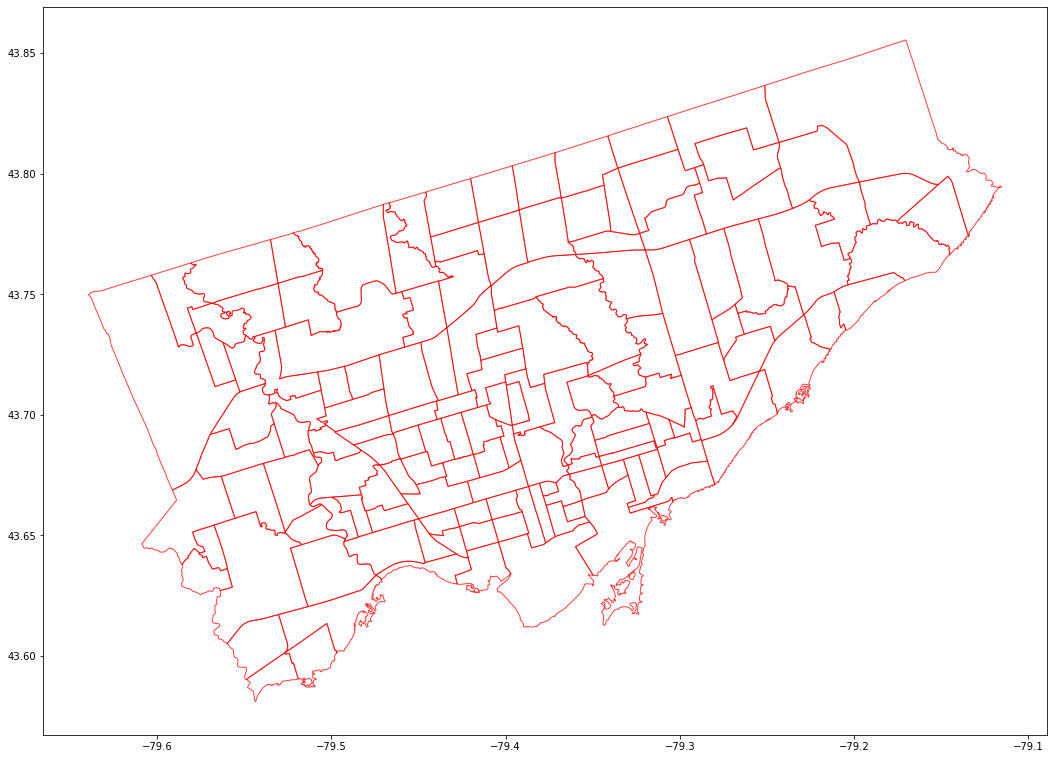

In [79]:
# check plot 
print(tor_nbs.geometry.crs)
print(tor_nbs.total_bounds)
ax = tor_nbs.plot(figsize=(18,14), 
                  edgecolor='red', 
                  facecolor='none', 
                  linewidth=1, 
                  alpha=0.75)

In [80]:
# save tor_nbs as a geodataframe

# Set save location
path = os.path.join('data','geo')
fn = 'tor_nbs.gpkg'

if not os.path.exists(path):
    print(f"Creating {path} under {os.getcwd()}")
    os.makedirs(path)
    
print(f"Using '{fn}' as basis for saving data...")

tor_nbs.to_file(os.path.join(path,fn), driver='GPKG')
print("Done.")

Using 'tor_nbs.gpkg' as basis for saving data...
Done.


epsg:4326
[-79.6392252   43.58709189 -79.12306224  43.85375245]


<AxesSubplot:>

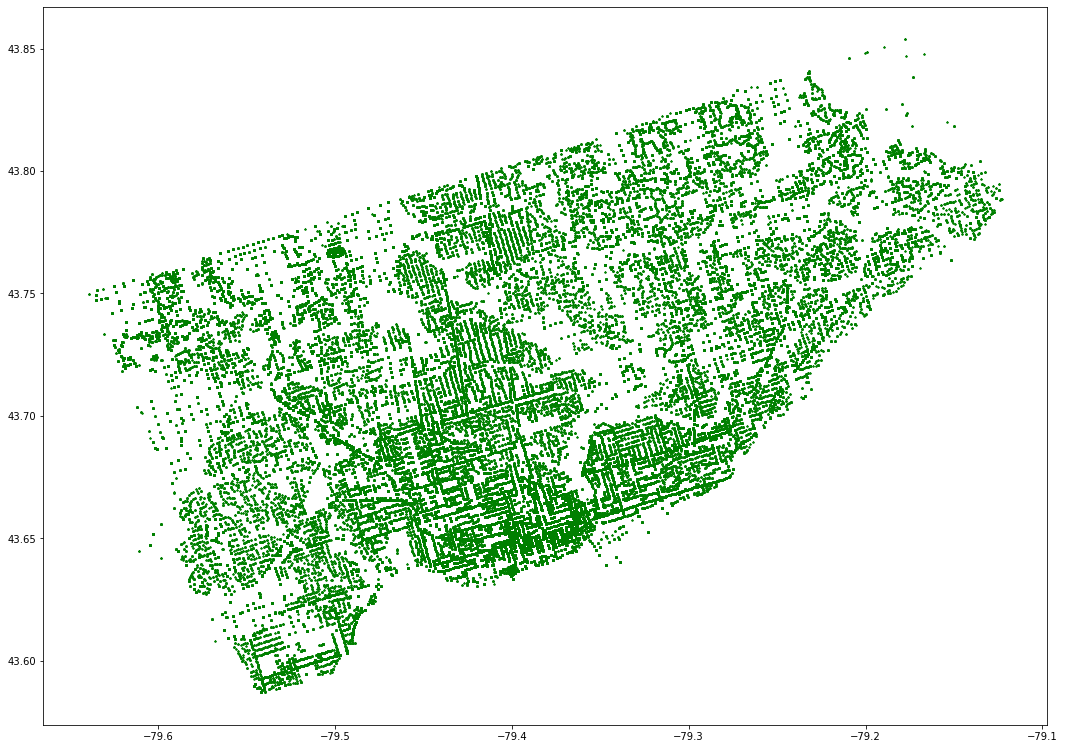

In [81]:
# now let's see how things look

# plot crime
print(crime.geometry.crs)
print(crime.total_bounds)
crime.plot(figsize=(18,14), marker='*', color='green', markersize=3)

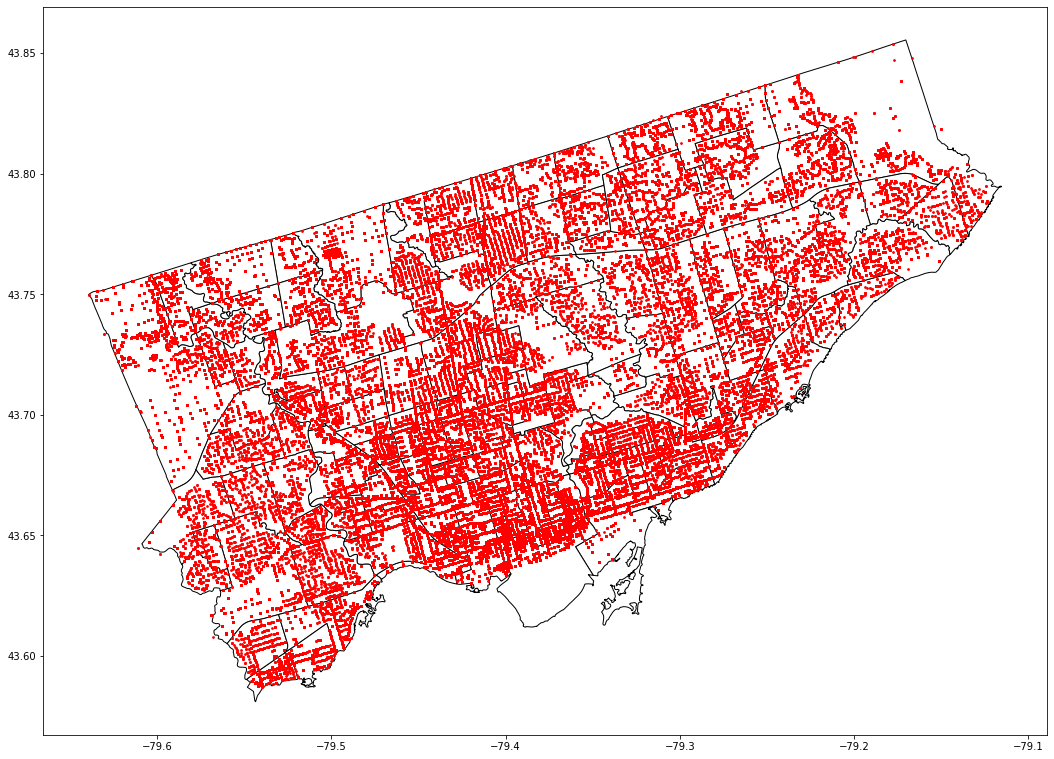

In [82]:
# add toronto neighbourhoods
base = tor_nbs.plot(figsize=(18,14), color='white', edgecolor='black')

# add crime locations
crime.plot(ax=base, figsize=(18,14), marker='o', color='red', markersize=3);

In [ ]:
# this looks good!
# NOTE - it appears that some dots along the edges are outside toronto
    # HOWEVER - documentation notes crime locations moved to closest intersection to maintain annonimity
    # AS A RESULT - All included points have been verified as within an identified Toronto Neighbourhood, but may not appear so visually